## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.

In [1]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/ML')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [2]:
!cp '/content/drive/My Drive/Colab Notebooks/ML/data_final.tar.gz' sample_data/
!tar -xzvf sample_data/data_final.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
data_final/imgs/train/14064.npy
data_final/imgs/train/4814.npy
data_final/imgs/train/3575.npy
data_final/imgs/train/43348.npy
data_final/imgs/train/9030.npy
data_final/imgs/train/5332.npy
data_final/imgs/train/30079.npy
data_final/imgs/train/58179.npy
data_final/imgs/train/16560.npy
data_final/imgs/train/63721.npy
data_final/imgs/train/10156.npy
data_final/imgs/train/12270.npy
data_final/imgs/train/46279.npy
data_final/imgs/train/15110.npy
data_final/imgs/train/50716.npy
data_final/imgs/train/26363.npy
data_final/imgs/train/46743.npy
data_final/imgs/train/23527.npy
data_final/imgs/train/1563.npy
data_final/imgs/train/50803.npy
data_final/imgs/train/1497.npy
data_final/imgs/train/35964.npy
data_final/imgs/train/34341.npy
data_final/imgs/train/3278.npy
data_final/imgs/train/7084.npy
data_final/imgs/train/48695.npy
data_final/imgs/train/60687.npy
data_final/imgs/train/35932.npy
data_final/imgs/train/20156.npy
data_final/imgs/train/65244.npy
data_final/i

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json

%load_ext autoreload
%autoreload 2
from data_utils import MLDataset, collate_fn, augmentation_transforms, trainMLDataset
from modeling import Seq2SeqModel, TransformerSeq2Seq # You can import your custom model classes from modeling.py

## (Optional) Sample Visualization
You can see actual sample images and correct answers. Additional matplotlib package is needed.

In [ ]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i+1] = c

In [ ]:
# Just for reference: see actual samples
idx = 1234
sample = np.load(f'./data_final/imgs/train/{idx}.npy')
with open('./data_final/labels/train.json', 'r') as f:
    sample_target = json.load(f)[str(idx)]

tgt_char = ""
for i in sample_target:
    tgt_char += id_to_char[i]


print(f"Answer: {tgt_char} ({sample_target})")
print("Input image sequence:")

plt.figure(figsize=(5, len(sample)))
for i, img in enumerate(sample):
    plt.subplot(1, len(sample), i+1)
    plt.axis("off")
    plt.imshow(img)

## Device and seed setting

In [8]:
assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2 # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 8

## Model loading and training

In [34]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = trainMLDataset('data_final/imgs/train', 'data_final/labels/train.json', transform=None)
valid_ds = MLDataset('data_final/imgs/valid_normal', 'data_final/labels/valid_normal.json')
challenge_ds = MLDataset('data_final/imgs/valid_challenge', 'data_final/labels/valid_challenge.json')

# Apply data augmentation
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn= collate_fn, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
challenge_dl = DataLoader(challenge_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [10]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 128,
    'n_rnn_layers': 2,
    'rnn_dropout': 0.1,
    'embed_dim': 28,
    'customCNN': "CustomResnet",
    'nhead': 4,
    'dim_feedforward': 2048
}

In [18]:
model = TransformerSeq2Seq(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

model_optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# NOTE: you can define additional components like lr_scheduler, ...
lr_scheduler = torch.optim.lr_scheduler.StepLR(model_optim, step_size=15, gamma=0.1)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

TransformerSeq2Seq(
  (encoder): TransformerEncoder(
    (cnn): CustomResnet(
      (resnet): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [28]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 1000
max_epoch = 35

In [29]:
TrainingEpoch_loss = []
ValidationEpoch_loss = []

def train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=None, save_path='./model.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Implement your train function
    # Load your states
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        # ...

    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        step = 0
        train_loss = 0
        model.train()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device) # (B, T, H, W, C)
            target = target.to(device) # (B, T)
            #print(target[0, :])

            # start tokens should be located at the first position of the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
            # print(start_tokens[0])
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 5: implement loss calculation and optimization part
            # You can utilize teacher-forcing strategy to this part
            model_optim.zero_grad()
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)  # Teacher-forcing
            #print(decoder_input[0, :])
            logits = model(data, lengths, decoder_input)
            #print(logits.shape)
            loss = loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
            loss.backward()
            model_optim.step()
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            train_loss += loss.detach().cpu().item()
            step += 1
            if (batch_idx + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.detach().cpu().item())

        train_loss_avg = train_loss / (batch_idx+1)
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")
        TrainingEpoch_loss.append(train_loss_avg)

        valid_loss = 0
        model.eval()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):
            with torch.no_grad():
                data = data.to(device) # (B, T, H, W, C)
                target = target.to(device) # (B, T)

                # start tokens should be located at the first position of the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Implement loss calculation for valid batch (same as problem 5)
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)  # Teacher-forcing
                logits = model(data, lengths, decoder_input)
                loss = loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                valid_loss += loss.cpu().item()
        valid_loss /= (batch_idx + 1)
        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Save your states
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
                # ...
            }
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            torch.save(state, save_path)
            best_valid_loss = valid_loss
        print('valid epoch: %d, valid loss: %.5f, best valid loss: %.5f' % (epoch + 1, valid_loss, best_valid_loss))
        ValidationEpoch_loss.append(valid_loss)

    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################

    return

In [30]:
save_path=f'/content/drive/My Drive/{kwargs}.pt'
save_path

"/content/drive/My Drive/{'hidden_dim': 128, 'n_rnn_layers': 2, 'rnn_dropout': 0.1, 'embed_dim': 28, 'customCNN': 'CustomResnet', 'nhead': 4, 'dim_feedforward': 2048}.pt"

100%|██████████| 531/531 [04:04<00:00,  2.17it/s]


epoch 25, train loss: 0.041102903174225894


100%|██████████| 76/76 [00:23<00:00,  3.18it/s]


New best valid loss, saving model
valid epoch: 25, valid loss: 0.02855, best valid loss: 0.02855


100%|██████████| 531/531 [04:05<00:00,  2.16it/s]


epoch 26, train loss: 0.03842806815399513


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


valid epoch: 26, valid loss: 0.03298, best valid loss: 0.02855


100%|██████████| 531/531 [04:06<00:00,  2.15it/s]


epoch 27, train loss: 0.04030172036445073


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


valid epoch: 27, valid loss: 0.03035, best valid loss: 0.02855


100%|██████████| 531/531 [04:11<00:00,  2.11it/s]


epoch 28, train loss: 0.03650122422114604


100%|██████████| 76/76 [00:24<00:00,  3.08it/s]


valid epoch: 28, valid loss: 0.02884, best valid loss: 0.02855


100%|██████████| 531/531 [04:12<00:00,  2.10it/s]


epoch 29, train loss: 0.037084582898408006


100%|██████████| 76/76 [00:24<00:00,  3.08it/s]


valid epoch: 29, valid loss: 0.02859, best valid loss: 0.02855


100%|██████████| 531/531 [04:07<00:00,  2.14it/s]


epoch 30, train loss: 0.036968521380940846


100%|██████████| 76/76 [00:24<00:00,  3.06it/s]


valid epoch: 30, valid loss: 0.02932, best valid loss: 0.02855


100%|██████████| 531/531 [04:10<00:00,  2.12it/s]


epoch 31, train loss: 0.035977578471132365


100%|██████████| 76/76 [00:24<00:00,  3.07it/s]


valid epoch: 31, valid loss: 0.03078, best valid loss: 0.02855


100%|██████████| 531/531 [04:10<00:00,  2.12it/s]


epoch 32, train loss: 0.03466275795283964


100%|██████████| 76/76 [00:23<00:00,  3.19it/s]


New best valid loss, saving model
valid epoch: 32, valid loss: 0.02749, best valid loss: 0.02749


100%|██████████| 531/531 [04:09<00:00,  2.13it/s]


epoch 33, train loss: 0.035797068330050634


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


valid epoch: 33, valid loss: 0.03111, best valid loss: 0.02749


100%|██████████| 531/531 [04:12<00:00,  2.10it/s]


epoch 34, train loss: 0.0349398096497197


100%|██████████| 76/76 [00:24<00:00,  3.15it/s]


valid epoch: 34, valid loss: 0.02908, best valid loss: 0.02749


100%|██████████| 531/531 [04:07<00:00,  2.15it/s]


epoch 35, train loss: 0.03363516034379517


100%|██████████| 76/76 [00:23<00:00,  3.18it/s]


New best valid loss, saving model
valid epoch: 35, valid loss: 0.02616, best valid loss: 0.02616


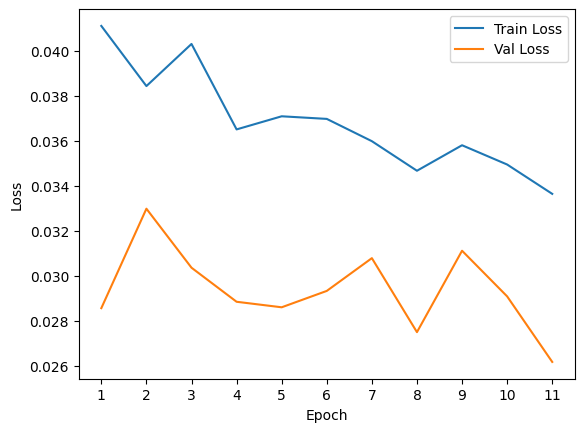

In [31]:
load_path = save_path #None
train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=load_path, save_path=save_path)

import matplotlib.pyplot as plt

epochs = range(1, len(TrainingEpoch_loss) + 1)
plt.plot(epochs, TrainingEpoch_loss, label='Train Loss')
plt.plot(epochs, ValidationEpoch_loss, label='Val Loss')

plt.xticks(epochs)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
ValidationEpoch_loss

[0.028553026274924998,
 0.03297546551881456,
 0.03035130017240973,
 0.028836983145753805,
 0.028591518798892043,
 0.029319877466677052,
 0.030776722577253456,
 0.02748650982730875,
 0.03110648663469443,
 0.029076440076000597,
 0.026162333467877226]

## Model evaluation

In [35]:
kwargs_generate = {
    # you can add arguments for your model's generate function
    'max_length': 10
}

In [36]:
# Do not modify this cell!

def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i+1] = c

    results = []
    labels = []
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):
        data = data.to(device) # (B, T, H, W, C)
        target = target.to(device) # (B, T)

        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(data, lengths, start_tokens, **kwargs_generate) # (B, T)

        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]

            results.append(decoded)

            decoded = ""
            for j in target[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)

    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [38]:
# load and evaluate your model
load_path = save_path #'/content/drive/My Drive/best3.pt'
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

print("Evaluation with chllenge set")
results, labels = eval(challenge_dl, load_path)

Evaluation with validation set


  0%|          | 0/76 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 76/76 [00:11<00:00,  6.89it/s]


Accuracy: 0.88645
Evaluation with chllenge set


100%|██████████| 69/69 [00:26<00:00,  2.60it/s]

Accuracy: 0.84427
